<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/data_cleaning/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skript um die Messdaten un Vorhersagedaten zusammen zu fühern und dieses zu bereinigen. Zudem werden weitere Features die für das Trainig des Netzwerks wichtig sind erzeugt.

Dateiname: Data_Cleaning

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA_and_Cleaning.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

## Installation der Bibliothek PVlib:
Dieses Modul wird für die Berechnung des Sonnenstandwinkels verwendet.

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installation der pvlib um den Sonnenstandswinkel zu berechnen
!pip install pvlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 13.7 MB/s eta 0:00:00


## Import der benötigten Module und allgemeines Setup:

In [3]:
# import der benötigten Module

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvlib
import warnings
import matplotlib
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from math import sqrt

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
# Standort der Messstaion für die Berechnung des Sonnenstandswinkel
latitude = 50.8
longitude = 7.2

# Angaben um das Datum und die Uhrzeit in Sin und Cos zu codieren
seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

tz, altitude, name = 'Europe/Berlin', 70, 'SanktAugustin'
tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

In [5]:
# Pfad zu den Messwerten / Vorhersagewerten und dem Speicherort auf Google Drive
# Import
folder_UVI = '/content/drive/My Drive/Colab_Notebooks/CSV_UVI/'
folder_Solys = '/content/drive/My Drive/Colab_Notebooks/SOLYS_CSV/'
folder_CAMS = '/content/drive/My Drive/Colab_Notebooks/CAMS_Vorhersage/'
folder_VarIdx = '/content/drive/My Drive/Colab_Notebooks/CAMS_Vorhersage/'
folder_save = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

name_UVI = ['22.06', '22.07', '22.08', '22.09', '22.10', '22.11', '22.12', '23.01', '23.02', '23.03', '23.04', '23.05', '23.07', '23.08']  # Hier wird angegeben, welche Monate importiert werden sollen
name_Solys = 'Solys_CSV'
name_CAMS = 'CAMS_std_CSV'
name_CAMS_Glo = 'CAMS_Glo_CSV'
name_CAMS_TCC = 'CAMS_TCC_CSV'
# name_VarIdx = 'blabla'

# Export

## Import der UVI-Messdaten:

Die Messdaten sind in CSV-Dateien gespeichert und müssen importiert werden.

In [6]:
## Code zum Import der Messdaten
dataframes = []
df_UVI_combined = []

for name in name_UVI:
  file_path = folder_UVI + name
  # print(file_path)
  df_import = pd.read_csv(file_path)
  dataframes.append(df_import)

df_UVI_combined = pd.concat(dataframes, ignore_index=True)
df_UVI_combined['Datetime'] = pd.to_datetime(df_UVI_combined['Datetime'])
df_UVI_combined.set_index('Datetime', inplace = True)
df_UVI_combined.drop(['Datum', 'Uhrzeit', 'Messzeitpunkt'], axis = 1)

,UVI,UVA,UVB,erythem
Datetime,,,,
2022-06-15 07:21:00,2.408378,4.686417,281.330695,0.060209
2022-06-15 07:23:00,2.462381,4.793073,287.094062,0.061560
2022-06-15 07:25:00,2.479048,4.817792,288.902613,0.061976
2022-06-15 07:27:00,2.543531,4.953151,292.450776,0.063588
2022-06-15 07:29:00,2.576485,5.016957,295.552724,0.064412
...,...,...,...,...
2023-08-12 18:34:00,0.024202,0.016610,7.669374,0.000605
2023-08-12 18:36:00,0.020477,0.014359,6.381634,0.000512
2023-08-12 18:38:00,0.019234,0.013251,6.252191,0.000481


## Import der Solys-Messdaten:

Messdaten mit einer 2-minütigen Auflösung. Die Daten sind noch nicht reduziert.

In [7]:
# Einlesen der Solys-Messdaten:
df_Solys = pd.read_csv(folder_Solys + name_Solys)

# Die Spalte mit dem Zeitstempel in das Datetimeformat umwandeln und als Index speichern
df_Solys['Datetime'] = pd.to_datetime(df_Solys['Datetime'])
df_Solys.set_index('Datetime', inplace = True)

In [8]:
df_Solys

,Glo,Dif,Glo_SPLite,Dir,Temp
Datetime,,,,,
2022-04-25 08:06:00,245.833333,246.866667,259.233333,2.400000,10.766667
2022-04-25 08:08:00,237.058333,237.666667,249.200000,2.350000,10.658333
2022-04-25 08:10:00,206.466667,206.675000,217.633333,2.316667,10.058333
2022-04-25 08:12:00,188.858333,189.400000,200.900000,2.316667,10.608333
2022-04-25 08:14:00,186.991667,187.616667,199.800000,2.208333,10.391667
...,...,...,...,...,...
2023-11-09 08:10:00,9.975000,10.500000,11.266667,1.400000,8.683333
2023-11-09 08:12:00,10.233333,10.741667,11.291667,1.400000,8.708333
2023-11-09 08:14:00,10.775000,11.275000,11.691667,1.416667,8.716667


## Import der CAMS-Vorhersagedaten:

Die Daten sind noch nicht reduziert und es gibt für jede Stunde des Tages eine Vorhersage.

In [9]:
# Einlesen der Solys-Messdaten:
df_CAMS = pd.read_csv(folder_CAMS + name_CAMS)

# Die Spalte mit dem Zeitstempel in das Datetimeformat umwandeln und als Index speichern
df_CAMS['Datetime'] = pd.to_datetime(df_CAMS['Datetime'])
df_CAMS.set_index('Datetime', inplace = True)

In [10]:
df_CAMS

,aod469,aod550,gtco3,uvbed,uvbedcs,hcc,lcc,tcc
Datetime,,,,,,,,
2022-06-01 00:00:00,0.261836,0.211588,0.008161,-5.551115e-16,5.551115e-16,0.000000,0.000000,0.504647
2022-06-01 01:00:00,0.272371,0.220283,0.008044,-5.551115e-16,5.551115e-16,0.000000,0.000000,0.681122
2022-06-01 02:00:00,0.237297,0.190401,0.007992,-5.551115e-16,5.551115e-16,0.124487,0.015687,0.414249
2022-06-01 03:00:00,0.195020,0.155880,0.007971,-5.551115e-16,5.551115e-16,0.071994,0.005310,0.076343
2022-06-01 04:00:00,0.164975,0.131777,0.007959,7.204596e-02,7.198133e-02,0.000000,0.001114,0.001785
...,...,...,...,...,...,...,...,...
2023-07-31 19:00:00,0.131174,0.109557,0.006663,5.551115e-16,5.551115e-16,1.000000,0.259121,1.000000
2023-07-31 20:00:00,0.126791,0.106162,0.006666,5.551115e-16,5.551115e-16,1.000000,0.473365,1.000000
2023-07-31 21:00:00,0.133466,0.111809,0.006700,5.551115e-16,5.551115e-16,0.999878,0.934537,1.000000


## Import der CAMS-Globalstrahlungs-Vorhersagedaten:

In [11]:
# Einlesen der Solys-Messdaten:
df_CAMS_GLO = pd.read_csv(folder_CAMS + name_CAMS_Glo)

# Die Spalte mit dem Zeitstempel in das Datetimeformat umwandeln und als Index speichern
df_CAMS_GLO['Datetime'] = pd.to_datetime(df_CAMS_GLO['Observation_period'])
df_CAMS_GLO.set_index('Datetime', inplace = True)
df_CAMS_GLO.drop(['Unnamed: 0', 'Observation_period'], axis = 1)

,Clear_sky_GHI,Clear_sky_BHI,GHI,BHI
Datetime,,,,
2022-06-01 00:01:00,0.0,0.0,0.0,0.0
2022-06-01 00:03:00,0.0,0.0,0.0,0.0
2022-06-01 00:05:00,0.0,0.0,0.0,0.0
2022-06-01 00:07:00,0.0,0.0,0.0,0.0
2022-06-01 00:09:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2023-08-31 23:51:00,0.0,0.0,0.0,0.0
2023-08-31 23:53:00,0.0,0.0,0.0,0.0
2023-08-31 23:55:00,0.0,0.0,0.0,0.0


## Import der CAMS-TCC-Vorhersagedaten:

In [12]:
# Einlesen der Solys-Messdaten:
df_CAMS_TCC = pd.read_csv(folder_CAMS + name_CAMS_TCC, index_col=[0, 1])

# ! Der Index muss noch in Datetime umgewndelt werden !

# Die Spalte mit dem Zeitstempel in das Datetimeformat umwandeln und als Index speichern
# df_CAMS_TCC['Datetime'] = pd.to_datetime(df_CAMS_TCC['Datetime'])
# df_CAMS_TCC.set_index('Datetime', inplace = True)

In [13]:
# df_CAMS_TCC

## Zusammenführen der DataFrames zu einem gemeinsamen DataFrame

Die CAMS-Solarstrahlungsdaten, Solys und UVI-Messdaten werden zusammengefügt.

In [14]:
def merge_asof_multiple_dfs(dfs, tolerance=pd.Timedelta('1 minute')):

    # Initialisiere das finale DataFrame mit dem ersten DataFrame in der Liste
    final_df = dfs[0].sort_values('Datetime')

    # Iteriere über die restlichen DataFrames in der Liste und führe sie schrittweise zusammen
    for df in dfs[1:]:
        df = df.sort_values('Datetime')
        final_df = pd.merge_asof(final_df, df, on='Datetime', tolerance=tolerance, direction='nearest')

    return final_df

In [15]:
# Zusammenführen der Dataframes
dataframes = [df_CAMS_GLO, df_UVI_combined, df_Solys]  # df_CAMS_TCC

df_complete = []
df_complete = merge_asof_multiple_dfs(dataframes).copy()
df_complete.set_index('Datetime', inplace = True)

In [16]:
# Umbenennen der Spalte Glo in ghi

df_complete.rename(columns={'Glo': 'ghi'}, inplace=True)

In [17]:
df_complete

,Unnamed: 0,Observation_period,Clear_sky_GHI,Clear_sky_BHI,GHI,BHI,UVI,UVA,UVB,erythem,Datum,Uhrzeit,Messzeitpunkt,ghi,Dif,Glo_SPLite,Dir,Temp
Datetime,,,,,,,,,,,,,,,,,,
2022-06-01 00:01:00,0,2022-06-01 00:01:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.275000,10.600
2022-06-01 00:03:00,1,2022-06-01 00:03:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.266667,10.575
2022-06-01 00:05:00,2,2022-06-01 00:05:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.300000,10.550
2022-06-01 00:07:00,3,2022-06-01 00:07:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.283333,10.525
2022-06-01 00:09:00,4,2022-06-01 00:09:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.225000,10.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 23:51:00,329035,2023-08-31 23:51:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.516667,13.900
2023-08-31 23:53:00,329036,2023-08-31 23:53:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.583333,13.900
2023-08-31 23:55:00,329037,2023-08-31 23:55:00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.600000,13.900


In [18]:
# Alle NAN-Einträge entfernen
df_complete = df_complete.dropna(subset=['UVI', 'ghi'])

In [19]:
df_complete.isna().sum()

Unnamed: 0            0
Observation_period    0
Clear_sky_GHI         0
Clear_sky_BHI         0
GHI                   0
BHI                   0
UVI                   0
UVA                   0
UVB                   0
erythem               0
Datum                 0
Uhrzeit               0
Messzeitpunkt         0
ghi                   0
Dif                   0
Glo_SPLite            0
Dir                   0
Temp                  0
dtype: int64

## Bereinigen der Messdaten

- Fehlende Messtage müssen ersetzt werden:
  - Prüfen, ob die UVI-Messwerte zusammenhängen.
  - Hinzufügen neuer Zeilen, falls die Messwerte nicht zusammen Hängen.

**Hier wird geprüft, ob die Messwerte zusammenhängend sind:**

In [20]:
def insert_missing_rows(df):
    # Sort the DataFrame by the 'Datetime' index
    df.sort_index(inplace=True)

    # Initialize a list to hold rows that need to be inserted
    rows_to_insert = []

    # Extract date from 'Datetime' index to facilitate grouping
    df['Datum'] = df.index.date

    # Group the DataFrame by 'Datum'
    grouped = df.groupby('Datum')

    if 'DiffGreater2' not in df.columns:
        df['DiffGreater2'] = 0

    for date, group in grouped:
        # Ensure the group is sorted by 'Datetime'
        group.sort_index(inplace=True)

        # Iterate through the group to find gaps in the data
        for i in range(1, len(group)):
            current_time = group.index[i]
            prev_time = group.index[i - 1]
            time_diff = current_time - prev_time

            # Check if the gap is greater than 2 minutes
            if time_diff > timedelta(minutes=2):
                while prev_time + timedelta(minutes=2) < current_time:
                    prev_time += timedelta(minutes=2)
                    new_row = {
                        'Datetime': prev_time,
                        'Datum': date,
                        'Uhrzeit': prev_time.time(),
                        'Messzeitpunkt': (prev_time - prev_time.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds(),
                        'erythem': 0,
                        'UVI': 0,
                        'UVA': 0,
                        'UVB':0,
                        'DiffGreater2': 1,
                    }
                    rows_to_insert.append(new_row)

    # Remove 'Datum' after processing
    # df.drop(columns='Datum', inplace=True)

    # Insert missing rows into a DataFrame
    if rows_to_insert:
        new_rows_df = pd.DataFrame(rows_to_insert)
        new_rows_df.set_index('Datetime', inplace=True)
        df = pd.concat([df, new_rows_df])

    # Sort the DataFrame by the 'Datetime' index
    df.sort_index(inplace=True)
    df = df.reset_index()
    # df['DiffGreater2'] = df['DiffGreater2'].fillna(0)

    return df.dropna(subset=['UVI'])

In [21]:
# Prüfen, ob die Messwerte Zusammenhängend
df_UVI_WRows = pd.DataFrame()
df_UVI_WRows = insert_missing_rows(df_complete)

<ipython-input-20-82382b77d5e1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datum'] = df.index.date
<ipython-input-20-82382b77d5e1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DiffGreater2'] = 0


In [22]:
df_UVI_WRows

,Datetime,Unnamed: 0,Observation_period,Clear_sky_GHI,Clear_sky_BHI,GHI,BHI,UVI,UVA,UVB,erythem,Datum,Uhrzeit,Messzeitpunkt,ghi,Dif,Glo_SPLite,Dir,Temp,DiffGreater2
0,2022-06-15 07:21:00,10300.0,2022-06-15 07:21:00,188.748,154.357,188.748,154.3570,2.408378,4.686417,281.330695,0.060209,2022-06-15,07:21:00,26460.0,554.483333,72.400000,567.525000,853.966667,27.258333,0
1,2022-06-15 07:23:00,10301.0,2022-06-15 07:23:00,190.480,155.933,190.480,155.9330,2.462381,4.793073,287.094062,0.061560,2022-06-15,07:23:00,26580.0,557.791667,73.475000,571.233333,851.991667,28.058333,0
2,2022-06-15 07:25:00,10302.0,2022-06-15 07:25:00,192.206,157.504,192.206,157.5040,2.479048,4.817792,288.902613,0.061976,2022-06-15,07:25:00,26700.0,561.708333,74.800000,574.766667,850.225000,28.616667,0
3,2022-06-15 07:27:00,10303.0,2022-06-15 07:27:00,193.924,159.068,193.924,159.0680,2.543531,4.953151,292.450776,0.063588,2022-06-15,07:27:00,26820.0,564.783333,75.383333,577.875000,848.400000,26.791667,0
4,2022-06-15 07:29:00,10304.0,2022-06-15 07:29:00,195.635,160.627,195.635,160.6270,2.576485,5.016957,295.552724,0.064412,2022-06-15,07:29:00,26940.0,571.850000,76.233333,584.958333,852.433333,28.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97440,2023-08-19 05:49:00,319854.0,2023-08-19 05:49:00,49.511,27.370,21.515,0.4624,0.306965,0.383479,77.133209,0.007674,2023-08-19,05:48:00,20880.0,232.516667,148.866667,251.808333,419.441667,24.183333,0
97441,2023-08-19 05:51:00,319855.0,2023-08-19 05:51:00,51.239,28.658,26.652,0.6105,0.312439,0.401176,76.895074,0.007811,2023-08-19,05:50:00,21000.0,233.466667,145.483333,252.866667,426.958333,24.375000,0
97442,2023-08-19 05:53:00,319856.0,2023-08-19 05:53:00,52.976,29.964,32.092,0.7705,0.314239,0.414659,75.176522,0.007856,2023-08-19,05:52:00,21120.0,215.358333,140.125000,232.941667,356.283333,24.550000,0
97443,2023-08-19 05:55:00,319857.0,2023-08-19 05:55:00,54.724,31.286,37.836,0.9425,0.316836,0.424958,74.945108,0.007921,2023-08-19,05:54:00,21240.0,215.333333,134.258333,233.008333,372.275000,24.800000,0


## Sonnenstandswinkel hinzufügen

In [23]:
def calculate_solar_zenith_angle(dataframe, date_column, latitude, longitude, altitude=0):

    # Kopieren des ursprünglichen DataFrames.
    result_df = dataframe.copy()

    # Konvertiere der Datumsspalte in einen datetime-Datentyp, falls sie dies nicht bereits ist.
    if not pd.api.types.is_datetime64_any_dtype(dataframe[date_column]):
        result_df[date_column] = pd.to_datetime(dataframe[date_column])

    # Iteriere über die Zeilen des DataFrames und berechne den Solarzenitwinkel für jedes Datum.
    solar_zenith_angles = []
    for date in result_df[date_column]:
        solar_position = pvlib.solarposition.get_solarposition(date, latitude, longitude, altitude)
        solar_zenith_angle = solar_position['zenith'].values[0]
        solar_zenith_angles.append(solar_zenith_angle)

    # Füge die berechneten Solarzenitwinkel dem DataFrame hinzu.
    result_df['SZA'] = solar_zenith_angles

    return result_df

In [24]:
df_complete_WRows_SZ = pd.DataFrame()
df_complete_WRows_SZ = calculate_solar_zenith_angle(df_complete, 'Observation_period', latitude, longitude)

In [25]:
df_complete

,Unnamed: 0,Observation_period,Clear_sky_GHI,Clear_sky_BHI,GHI,BHI,UVI,UVA,UVB,erythem,Datum,Uhrzeit,Messzeitpunkt,ghi,Dif,Glo_SPLite,Dir,Temp,DiffGreater2
Datetime,,,,,,,,,,,,,,,,,,,
2022-06-15 07:21:00,10300,2022-06-15 07:21:00,188.748,154.357,188.748,154.3570,2.408378,4.686417,281.330695,0.060209,2022-06-15,07:21:00,26460.0,554.483333,72.400000,567.525000,853.966667,27.258333,0
2022-06-15 07:23:00,10301,2022-06-15 07:23:00,190.480,155.933,190.480,155.9330,2.462381,4.793073,287.094062,0.061560,2022-06-15,07:23:00,26580.0,557.791667,73.475000,571.233333,851.991667,28.058333,0
2022-06-15 07:25:00,10302,2022-06-15 07:25:00,192.206,157.504,192.206,157.5040,2.479048,4.817792,288.902613,0.061976,2022-06-15,07:25:00,26700.0,561.708333,74.800000,574.766667,850.225000,28.616667,0
2022-06-15 07:27:00,10303,2022-06-15 07:27:00,193.924,159.068,193.924,159.0680,2.543531,4.953151,292.450776,0.063588,2022-06-15,07:27:00,26820.0,564.783333,75.383333,577.875000,848.400000,26.791667,0
2022-06-15 07:29:00,10304,2022-06-15 07:29:00,195.635,160.627,195.635,160.6270,2.576485,5.016957,295.552724,0.064412,2022-06-15,07:29:00,26940.0,571.850000,76.233333,584.958333,852.433333,28.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 05:49:00,319854,2023-08-19 05:49:00,49.511,27.370,21.515,0.4624,0.306965,0.383479,77.133209,0.007674,2023-08-19,05:48:00,20880.0,232.516667,148.866667,251.808333,419.441667,24.183333,0
2023-08-19 05:51:00,319855,2023-08-19 05:51:00,51.239,28.658,26.652,0.6105,0.312439,0.401176,76.895074,0.007811,2023-08-19,05:50:00,21000.0,233.466667,145.483333,252.866667,426.958333,24.375000,0
2023-08-19 05:53:00,319856,2023-08-19 05:53:00,52.976,29.964,32.092,0.7705,0.314239,0.414659,75.176522,0.007856,2023-08-19,05:52:00,21120.0,215.358333,140.125000,232.941667,356.283333,24.550000,0


## Zeit und Datum in Sin und Cos codieren
- Cyclical Encoding der Messzeit als Sinus und Cosinus

In [26]:
def calculate_date_in_sine_cosine(dataframe, day, year):

    # kopieren des ursprünglichen DataFrames
    result_df = dataframe.copy()

    # berechnen der Uhrzeit und des Datums als Sin und Cos
    result_df['time_sin'] = np.sin(2*np.pi*result_df['Messzeitpunkt']/day)
    result_df['time_cos'] = np.cos(2*np.pi*result_df['Messzeitpunkt']/day)
    result_df['date_sin'] = np.sin((2*np.pi*result_df['Observation_period'].dt.dayofyear * 24 * 60 * 60) / year)
    result_df['date_cos'] = np.cos((2*np.pi*result_df['Observation_period'].dt.dayofyear * 24 * 60 * 60) / year)

    return result_df

In [27]:
# Erweitern des DataFrames mit den UVI-Messwerten um den Solarzenitwinkel um die Uhrzeit als Sin/Cos
df_complete_SZ_SC = calculate_date_in_sine_cosine(df_complete_WRows_SZ, seconds_in_day, seconds_in_year)

## Erstellen einer Liste mit Stunden an denen es Messwerte gibt:

In [28]:
# Herausschreiben des Datums und der Stunde aus den Messdaten um im Folgeden nur die relevanten Vorhersagedaten auszuwählen
df_complete_SZ_SC['Date'] = df_complete_SZ_SC['Observation_period'].dt.date
df_complete_SZ_SC['Hour'] = df_complete_SZ_SC['Observation_period'].dt.hour

df_date_std = df_complete_SZ_SC.groupby(['Date', 'Hour']).size().reset_index(name='Count')
# DateTime-Splate mit dem Messzeitpunkt hinzufügen
df_date_std['Observation_period'] = pd.to_datetime(df_date_std['Date'].astype(str) + ' ' + df_date_std['Hour'].astype(str) + ':00:00')
# DateTime-Spalte als Index setzen
df_date_std.set_index('Observation_period', inplace=True)

In [29]:
# Liste mit Stunden an denen es Messwerte gibt. Bei 2 Min. Auslösung sollte es für jede Stunde 30 Messwerte geben.
df_date_std

,Date,Hour,Count
Observation_period,,,
2022-06-15 07:00:00,2022-06-15,7,13
2022-06-15 08:00:00,2022-06-15,8,23
2022-06-15 09:00:00,2022-06-15,9,30
2022-06-15 10:00:00,2022-06-15,10,29
2022-06-15 11:00:00,2022-06-15,11,30
...,...,...,...
2023-08-18 16:00:00,2023-08-18,16,30
2023-08-18 17:00:00,2023-08-18,17,30
2023-08-18 18:00:00,2023-08-18,18,14


## Variablilitäts Klassifikatoren:

### Funktionen:

In [30]:
# Klasse für den Klassifokator nach Skarveit

def sigma_skartveit_GHI(rad_df, cs):
    # Index nach Skarveit
    # berechnen des Variabiltätsindex sigma_skarveit_GHI mit Hilfe der Globalstrahlung
        """
        Eq. (3.1)
        paper uses DNI values. Here GHI
        can reach values above 1
        Skartveit A., J.A. Olseth, M.E. Tuft, 1998: An hourly
        diffuse fraction model with correction for variability
        and surface albedo. – Sol. Energy 63, 173–183, DOI:
        10.1016/S0038-092X(98)00067-X.

        Returns
        -------
        sigma_skartveit

        """
        # tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

        # kc = Clear-Sky-Index | kc_t_m1 = Clear-Sky-Index of previus hour | kc_t_p1 = Clear-Sky-Index following hour
        kc = []
        kc_t_m1 = []
        kc_t_p1 = []
        i = 0

        # füllen von kc | kc_t_m1 | kc_t_p1
        for i in range(1,len(rad_df['ghi'])-1):
            kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
            kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
            kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])

        # Berechnung der arthmetischen Mittelwerte
        kc = np.array(kc).mean()
        kc_t_m1 = np.array(kc_t_m1).mean()
        kc_t_p1 = np.array(kc_t_p1).mean()

        # Umsetzung der Gleichung 3.1 für die GHI
        return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)

In [31]:
def V_combria_GHI(rad_df, cs):
        # Index nach Combria
        # Standardabweichung der zeitlichen Unterschiede von Kc
        """
        Eq. (3.2)
        paper uses DNI values. Here GHI
        can reach values above 1
        Coimbra, C.F.M., J. Kleissl, R. Marquez, 2013: Overview of
        Solar-Forecasting Methods and a Metric for Accuracy Evaluation. – In: Kleissl, J. (Ed.): Solar Energy Forecasting and
        Resource Assessment. Oxford, 171–194.

        Returns
        -------
        V

        """
        V=0
        i=0
        kc = []
        kc_t_p1 = []
        delta_kc = []


        for i in range(len(rad_df['ghi'])-1):
            kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
            kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
            delta_kc = kc-kc_t_p1
            V = V+(delta_kc)**2

        # Umsetzung der Gleichung 3.2 für die GHI
        return sqrt(V/(i+1)), kc

In [32]:
def VI_stein_GHI(rad_df, cs):
        # Index nach Stein
        """
        Eq. (3.2)
        paper uses DNI values. Here GHI
        can reach values above 1
        Stein, J.S., M.J. Reno, C. Hansen, 2012: The variability index: a new and novel metric for quantifying irradiance and
        PV output variability. – In: World Renewable Energy Forum,
        Denver, CO.

        Returns
        -------
        VI
        """

        summe1 = sum(((rad_df['ghi'].diff().dropna()**2)+1)**(1/2))
        summe2 = sum(((cs['ghi'].diff().dropna()**2)+1)**(1/2))

        # Bedingte Überprüfung und Zuweisung
        ergebnis = summe1 / summe2 if summe2 != 0 else np.nan

        return ergebnis

In [33]:
stundliche_gruppe = df_complete_SZ_SC.groupby([df_complete_SZ_SC.index.date, df_complete_SZ_SC.index.hour])

df_std_ind = pd.DataFrame()
df_temp = pd.DataFrame()
stundliche_indizes = []
Messpunkt = []
temp_dfs = []

for datum, gruppe in stundliche_gruppe:
    if not gruppe.empty:  # Überprüfen, ob die Gruppe Daten enthält

        cs = tus.get_clearsky(gruppe.index)

        index_sigma = sigma_skartveit_GHI(gruppe, cs)
        index_coimbra, kc = V_combria_GHI(gruppe, cs)
        index_stein = VI_stein_GHI(gruppe, cs)

        temp_df = pd.DataFrame({'Datetime': [datum], 'index_sigma': [index_sigma], 'index_coimbra': [index_coimbra]
                                          , 'index_stein': [index_stein], 'kc' : [kc]})
        temp_dfs.append(temp_df)

df_std_ind = pd.concat(temp_dfs, ignore_index=True)

### Nachbearbeitung der Dataframes:

In [34]:
# Das Datums-Tuple aufteilen und als Datetimeindex speichern
def tuple_to_datetime(tup):
    datum, stunde = tup  # Tupel auspacken
    return datetime.strptime(f'{datum} {stunde}', '%Y-%m-%d %H')

# Anwenden der Funktion auf die Spalte 'date'
df_std_ind['Datetime'] = pd.to_datetime(df_std_ind['Datetime'].apply(tuple_to_datetime)).copy()
df_std_ind.set_index('Datetime', inplace=True)

In [35]:
# Alle nan Einträge löschen
df_std_ind.dropna(inplace = True)
df_std_ind = df_std_ind[~np.isinf(df_std_ind['index_sigma'])]
df_std_ind.max()

index_sigma       257.201079
index_coimbra    1863.529392
index_stein        217.34792
kc                163.393628
dtype: object

In [36]:
df_std_ind

,index_sigma,index_coimbra,index_stein,kc
Datetime,,,,
2022-06-15 07:00:00,0.001513,0.006227,1.013232,1.123078
2022-06-15 08:00:00,0.000495,0.003971,1.047828,1.100615
2022-06-15 09:00:00,0.000208,0.001217,1.038654,1.09157
2022-06-15 10:00:00,0.000030,0.001455,1.139255,1.093201
2022-06-15 11:00:00,0.000033,0.001212,1.300181,1.094283
...,...,...,...,...
2023-08-18 15:00:00,0.004162,0.073342,4.007741,0.907768
2023-08-18 16:00:00,0.004121,0.039716,1.552568,1.085214
2023-08-18 17:00:00,0.008878,0.181251,2.517242,1.339867


## Verbinden des Dataframes mit den Varabilitäts-Indizes mit den CAMS-Vorhersagedaten:

In [37]:
df_CAMS_VarIdx = []
df_CAMS_VarIdx = pd.concat([df_CAMS, df_std_ind], axis = 1).dropna(subset=['index_sigma', 'uvbed'])

In [81]:
# Spalte mit der Uhrzeit einfügen

df_CAMS_VarIdx['Uhrzeit'] = df_CAMS_VarIdx.index.time

In [82]:
df_CAMS_VarIdx

,aod469,aod550,gtco3,uvbed,uvbedcs,hcc,lcc,tcc,index_sigma,index_coimbra,index_stein,kc,Uhrzeit
Datetime,,,,,,,,,,,,,
2022-06-15 07:00:00,0.113836,0.090709,0.006980,2.215356,2.215710,0.080463,0.000000,0.080463,0.001513,0.006227,1.013232,1.123078,07:00:00
2022-06-15 08:00:00,0.117419,0.093593,0.006992,3.720213,3.720863,0.160896,0.000000,0.160896,0.000495,0.003971,1.047828,1.100615,08:00:00
2022-06-15 09:00:00,0.123622,0.098543,0.007008,5.303602,5.304939,0.242443,0.000000,0.242443,0.000208,0.001217,1.038654,1.09157,09:00:00
2022-06-15 10:00:00,0.130051,0.103720,0.007030,6.594754,6.596219,0.261090,0.000000,0.261090,0.000030,0.001455,1.139255,1.093201,10:00:00
2022-06-15 11:00:00,0.131761,0.105100,0.007057,7.249422,7.249653,0.053088,0.000000,0.053088,0.000033,0.001212,1.300181,1.094283,11:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25 14:00:00,0.401388,0.331109,0.007651,2.239130,3.816758,0.898616,0.425038,0.967482,0.005382,0.013876,1.490806,0.239587,14:00:00
2023-07-25 15:00:00,0.388010,0.319326,0.007636,1.960286,2.528358,0.990844,0.077686,0.992981,0.011962,0.170857,11.719471,0.81545,15:00:00
2023-07-25 16:00:00,0.371810,0.305458,0.007628,0.971196,1.395423,1.000000,0.212443,1.000000,0.012190,0.020193,1.370512,0.228188,16:00:00


## Prüfen ob der Dataframe richtig ist:

In [39]:
df_complete_SZ_SC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96768 entries, 2022-06-15 07:21:00 to 2023-08-19 05:57:00
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          96768 non-null  int64         
 1   Observation_period  96768 non-null  datetime64[ns]
 2   Clear_sky_GHI       96768 non-null  float64       
 3   Clear_sky_BHI       96768 non-null  float64       
 4   GHI                 96768 non-null  float64       
 5   BHI                 96768 non-null  float64       
 6   UVI                 96768 non-null  float64       
 7   UVA                 96768 non-null  float64       
 8   UVB                 96768 non-null  float64       
 9   erythem             96768 non-null  float64       
 10  Datum               96768 non-null  object        
 11  Uhrzeit             96768 non-null  object        
 12  Messzeitpunkt       96768 non-null  float64       
 13  ghi        

In [40]:
df_complete_SZ_SC.isnull().sum()

Unnamed: 0            0
Observation_period    0
Clear_sky_GHI         0
Clear_sky_BHI         0
GHI                   0
BHI                   0
UVI                   0
UVA                   0
UVB                   0
erythem               0
Datum                 0
Uhrzeit               0
Messzeitpunkt         0
ghi                   0
Dif                   0
Glo_SPLite            0
Dir                   0
Temp                  0
DiffGreater2          0
SZA                   0
time_sin              0
time_cos              0
date_sin              0
date_cos              0
Date                  0
Hour                  0
dtype: int64

## Abspeichern des DataFrames als CSV:

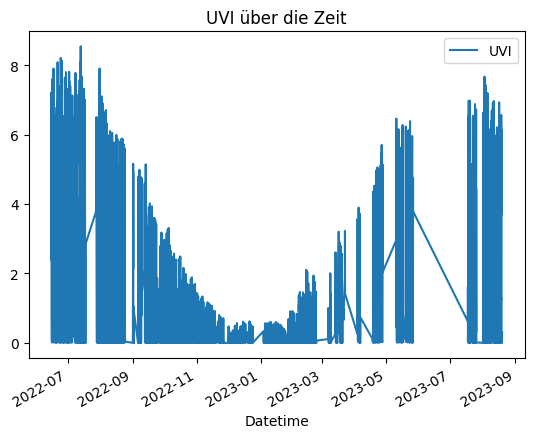

In [41]:
# Irradiance metrics over time
df_complete_SZ_SC[['UVI']].plot()
plt.title('UVI über die Zeit');

In [42]:
def export_dataframes_to_csv(df1, df2, file1_name, file2_name, folder_name):

    try:
        # Exportiere den ersten DataFrame in eine CSV-Datei
        df1.to_csv(folder_name + file1_name)
        print(f'DataFrame 1 wurde erfolgreich in "{file1_name}" exportiert.')

        # # Exportiere den zweiten DataFrame in eine CSV-Datei
        df2.to_csv(folder_name + file2_name)
        print(f'DataFrame 2 wurde erfolgreich in "{file2_name}" exportiert.')

        # # Exportiere den dritten DataFrame in eine CSV-Datei
        # df3.to_csv(folder_name + file3_name)
        # print(f'DataFrame 3 wurde erfolgreich in "{file3_name}" exportiert.')

    except Exception as e:
        print(f'Fehler beim Export der DataFrames: {str(e)}')

In [43]:
# export_dataframes_to_csv(df_complete_SZ_SC, df_CAMS_VarIdx, 'Messdaten_CAMS_GHI.csv', 'Vorhersagedaten_CAMS_VarIdx', folder_save)

## Sonstiges:

In [51]:
# Clear Sky Tage finden:

start_time = '10:00:00'
end_time = '15:00:00'

df_filtered = pd.DataFrame()
indices_to_keep = []

# filtern nach relevanten Uhrzeiten
indices_to_keep = df_CAMS_VarIdx.between_time(start_time, end_time).index

In [52]:
df_filtered = df_CAMS_VarIdx.between_time(start_time, end_time)

In [58]:
df_filtered.sort_values(by='index_stein', ascending=False).head(20)

,aod469,aod550,gtco3,uvbed,uvbedcs,hcc,lcc,tcc,index_sigma,index_coimbra,index_stein,kc
Datetime,,,,,,,,,,,,
2023-05-16 11:00:00,0.099268,0.079565,0.007759,5.233665,6.034910,0.012223,0.362230,0.388400,0.017999,0.371693,217.347920,0.682654
2022-07-15 11:00:00,0.128294,0.103105,0.007120,6.396704,6.932554,0.007111,0.309523,0.316207,0.032634,0.385169,216.303797,1.280326
2022-09-17 11:00:00,0.109756,0.097137,0.007112,1.633601,3.703007,0.003708,1.000000,1.000000,0.019584,0.392626,164.943719,1.431921
2022-09-01 11:00:00,0.232856,0.189367,0.006702,2.152879,4.767883,0.000000,0.873896,0.881693,0.014009,0.354068,157.852810,1.226632
2022-07-02 12:00:00,0.071274,0.056628,0.006758,7.658632,7.663342,0.000000,0.008026,0.008026,0.002458,0.413938,153.376034,1.139485
2022-06-24 11:00:00,0.186544,0.151761,0.007249,5.802017,6.982068,0.367647,0.131720,0.552119,0.005216,0.256280,151.800373,1.299153
2022-07-16 11:00:00,0.161829,0.130529,0.007015,4.925468,6.917518,0.000000,0.024217,0.769856,0.010941,0.306753,151.092874,1.09607
2022-09-29 11:00:00,0.127479,0.103070,0.007235,2.154923,2.860651,1.000000,0.121084,1.000000,0.009704,0.367070,143.128424,1.471921
2023-05-16 10:00:00,0.113402,0.090921,0.007729,5.073841,5.465478,0.000000,0.245098,0.310668,0.007430,0.425743,141.533948,0.375273


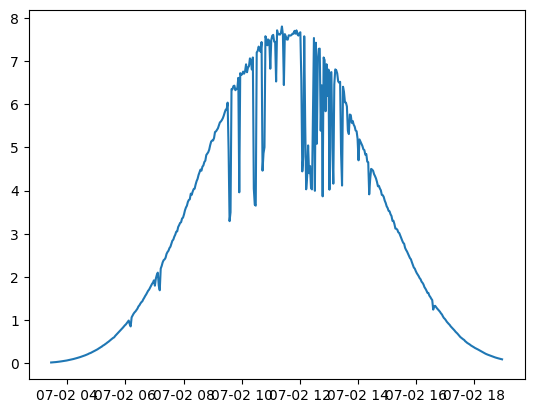

In [65]:
# Plotten eines interessanten Datums
gewünschtes_datum = '2022-07-02'
gefilterte_daten = df_filtered[df_filtered.index.date == pd.to_datetime(gewünschtes_datum).date()]
UVI_gefiltert = df_complete['UVI'][df_complete.index.date == pd.to_datetime(gewünschtes_datum).date()]
plt.plot(UVI_gefiltert)

In [84]:
def plot_dual_axis(df1, df2, x1, y1, x2, y2, label1='Data 1', label2='Data 2', title='Dual Axis Plot'):

    fig, ax1 = plt.subplots()

    # Plotting the first DataFrame
    color = 'tab:blue'
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel(label1, color=color)
    ax1.plot(df1[x1], df1[y1], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis for the second DataFrame
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(label2, color=color)
    ax2.plot(df2[x2], df2[y2], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Adding title
    plt.title(title)

    fig.tight_layout()
    plt.show()

KeyError: 'GHI'

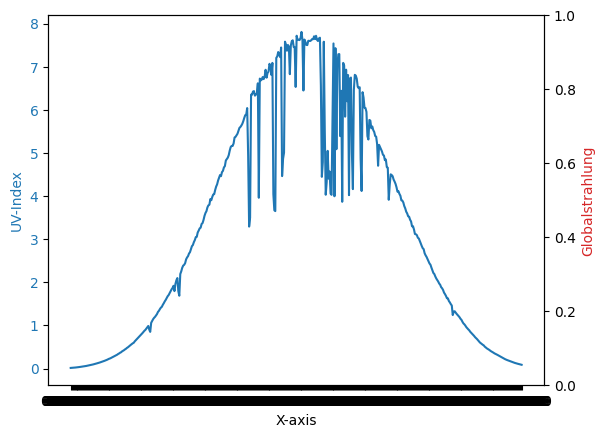

In [88]:
# Plotten eines Clear-Sky Tages:
gewünschtes_datum = '2022-07-02'

#
plot_dual_axis(df_complete[df_complete.index.date == pd.to_datetime(gewünschtes_datum).date()], df_CAMS_VarIdx[df_CAMS_VarIdx.index.date == pd.to_datetime(gewünschtes_datum).date()], 'Uhrzeit', 'UVI', 'Uhrzeit', 'GHI', 'UV-Index', 'Globalstrahlung', 'Aufstieg vs. Abstieg')

In [87]:
df_CAMS_VarIdx[df_CAMS_VarIdx.index.date == pd.to_datetime(gewünschtes_datum).date()]

,aod469,aod550,gtco3,uvbed,uvbedcs,hcc,lcc,tcc,index_sigma,index_coimbra,index_stein,kc,Uhrzeit
Datetime,,,,,,,,,,,,,
2022-07-02 03:00:00,0.089699,0.071706,0.006950,0.000000,0.000000,0.000000,0.000031,0.000031,12.455330,39.672191,1.920101,4.276426,03:00:00
2022-07-02 04:00:00,0.088980,0.071162,0.006904,0.077132,0.077178,0.000000,0.000305,0.000305,0.070711,0.094912,1.236252,1.506064,04:00:00
2022-07-02 05:00:00,0.087763,0.070171,0.006884,0.368130,0.368154,0.008286,0.000000,0.008286,0.007962,0.199293,3.223319,1.243696,05:00:00
2022-07-02 06:00:00,0.089640,0.071645,0.006876,1.028428,1.028459,0.032457,0.000000,0.032457,0.002572,0.002782,1.029248,1.161067,06:00:00
2022-07-02 07:00:00,0.093469,0.074642,0.006877,2.159465,2.159588,0.022157,0.000000,0.022157,0.000960,0.002018,1.061323,1.126675,07:00:00
2022-07-02 08:00:00,0.100907,0.080537,0.006871,3.689368,3.689296,0.000000,0.000000,0.000000,0.000552,0.002061,1.046401,1.118745,08:00:00
2022-07-02 09:00:00,0.113757,0.090818,0.006881,5.314985,5.314978,0.000000,0.000000,0.000000,0.008313,0.202136,24.234321,0.789723,09:00:00
2022-07-02 10:00:00,0.123292,0.098429,0.006908,6.576328,6.649332,0.000000,0.059039,0.059039,0.009560,0.240524,58.242954,1.139554,10:00:00
2022-07-02 11:00:00,0.129732,0.103612,0.006927,7.315043,7.370134,0.000000,0.056582,0.056582,0.003918,0.059647,25.771574,1.149743,11:00:00
